In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from scipy.stats import norm, skewnorm, gamma

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL

In [4]:
all_data = pd.read_csv("atmo_chem//cfnrtStation0002643.csv")

In [5]:
# all_data['time'] = list(pd.Timestamp(year=all_data.year.loc[i], month=all_data.month.loc[i], day=all_data.day.loc[i], hour=all_data.hour.loc[i]) for i in all_data.index)

In [41]:
all_data[['location', 'lat', 'lon', 'year','month', 'day', 'hour', 'ISO8601']]

location      lat      lon  year  month  day  hour  \
0      Station0002643  38.9701 -77.0167  2018      1    1     0   
1      Station0002643  38.9701 -77.0167  2018      1    1     1   
2      Station0002643  38.9701 -77.0167  2018      1    1     2   
3      Station0002643  38.9701 -77.0167  2018      1    1     3   
4      Station0002643  38.9701 -77.0167  2018      1    1     4   
...               ...      ...      ...   ...    ...  ...   ...   
23227  Station0002643  38.9701 -77.0167  2020      8    4    19   
23228  Station0002643  38.9701 -77.0167  2020      8    4    20   
23229  Station0002643  38.9701 -77.0167  2020      8    4    21   
23230  Station0002643  38.9701 -77.0167  2020      8    4    22   
23231  Station0002643  38.9701 -77.0167  2020      8    4    23   

                    ISO8601  
0      2018-01-01T00:00:00Z  
1      2018-01-01T01:00:00Z  
2      2018-01-01T02:00:00Z  
3      2018-01-01T03:00:00Z  
4      2018-01-01T04:00:00Z  
...                     ...  
23227  2020-08-04T19:30:00Z  
23228  2020-08-04T20:30:00Z  
23229  2020-08-04T21:30:00Z  
23230  2020-08-04T22:30:00Z  
23231  2020-08-04T23:30:00Z  

[23232 rows x 8 columns]

In [7]:
all_data.columns

Index(['ISO8601', 'location', 'lat', 'lon', 'CLDTT', 'PS', 'Q10M', 'T10M',
       'TPREC', 'TS', 'U10M', 'V10M', 'ZPBL', 'NO2', 'NO', 'NOy', 'O3', 'CO',
       'ACET', 'ALK4', 'ALD2', 'HCHO', 'C2H6', 'C3H8', 'BCPI', 'BCPO', 'OCPI',
       'OCPO', 'EOH', 'DST1', 'DST2', 'DST3', 'DST4', 'H2O2', 'HNO3', 'HNO4',
       'ISOP', 'MACR', 'MEK', 'MVK', 'N2O5', 'NH3', 'NH4', 'NIT', 'PAN',
       'PRPE', 'RCHO', 'SALA', 'SALC', 'SO2', 'SOAP', 'SOAS', 'TOLU', 'XYLE',
       'PM25_RH35_GCC', 'PM25ni_RH35_GCC', 'PM25su_RH35_GCC',
       'PM25ss_RH35_GCC', 'PM25du_RH35_GCC', 'PM25bc_RH35_GCC',
       'PM25oc_RH35_GCC', 'PM25soa_RH35_GCC', 'PM25_RH35_GOCART', 'EMIS_NO',
       'EMIS_CO', 'EMIS_ACET', 'EMIS_ALD2', 'EMIS_ALK4', 'EMIS_BENZ',
       'EMIS_C2H6', 'EMIS_C3H8', 'EMIS_HCHO', 'EMIS_EOH', 'EMIS_MEK',
       'EMIS_NH3', 'EMIS_PRPE', 'EMIS_TOLU', 'EMIS_XYLE', 'EMIS_ISOP',
       'EMIS_BCPI', 'EMIS_BCPO', 'EMIS_OCPI', 'EMIS_OCPO', 'EMIS_DST1',
       'EMIS_DST2', 'EMIS_DST3', 'EMIS_DST4', 'EMIS_S

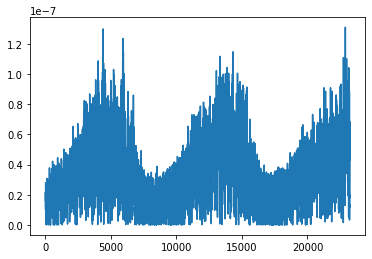

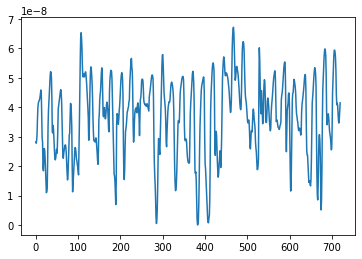

O3 





In [30]:
%matplotlib inline
for col in all_data.columns[16:17]:
    plt.plot(all_data[col].values)
    plt.show()
    plt.plot(all_data[col].iloc[2000:2720].values)
    plt.show()
    print(col, "\n\n\n")

In [9]:
# for flu data/integer data, use smooth parameter, discrete probability dist
# NO2, O3, NO, HNO4, ISOP, N2O5, NIT, PRPE, SOAP
# EMIS --all of them have very strong daily, weekly, and annual patterns
# EMIS_ISOP (cleaner version of NO)
%matplotlib notebook
# plt.plot(all_data.time, all_data.NO)

In [23]:
chemical = "O3"
x = np.expand_dims(all_data[chemical].values, -1)

In [24]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [25]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)

x (23232, 1)


In [26]:
plt.plot(x)

In [27]:
data_name = chemical

train_through = 2 * 365 * 24
train_start = 0
delay = 0  # 52 * 24  # 1.5 to 2 month gap, then 1 month forecast
x = x[train_start:]
predict_through = train_through + 24 * 365 * 8 // 12 + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [2, 2]
num_fourier = 2
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (23232, 1)
xt (17520, 1)


In [15]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [16]:
k.find_fourier_omegas(xt, hard_code=[24, 24 * 365.25])  # Day, Year
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

tensor([0.2618, 0.0007])

In [17]:
k.fit(xt, iterations=300, interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.17481185
Iteration  1
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.20172474
Iteration  2
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.22437361
Iteration  3
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.24533673
Iteration  4
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.26484695
Iteration  5
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.28362995
Iteration  6
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], 

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.69807076
Iteration  56
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.699088
Iteration  57
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.70005983
Iteration  58
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7006199
Iteration  59
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7020181
Iteration  60
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.70259154
Iteration  61
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.703281
Iterati

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.732917
Iteration  111
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7336336
Iteration  112
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7343366
Iteration  113
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.73474544
Iteration  114
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7355541
Iteration  115
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.736025
Iteration  116
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7363381
Ite

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7652501
Iteration  166
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7656557
Iteration  167
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7664389
Iteration  168
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.76701707
Iteration  169
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.76719093
Iteration  170
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.76796585
Iteration  171
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7687272

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.78948265
Iteration  221
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.789717
Iteration  222
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.78979576
Iteration  223
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7903034
Iteration  224
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7911892
Iteration  225
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7910965
Iteration  226
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.79124016


Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8018447
Iteration  276
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.80192554
Iteration  277
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8021247
Iteration  278
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.80201614
Iteration  279
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.80220336
Iteration  280
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8024061
Iteration  281
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8024289

In [28]:
params = k.predict(predict_through)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [33]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [34]:
quantiles = np.array([30, 60, 85, 98], dtype=np.float32) / 100
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

<IPython.core.display.Javascript object>


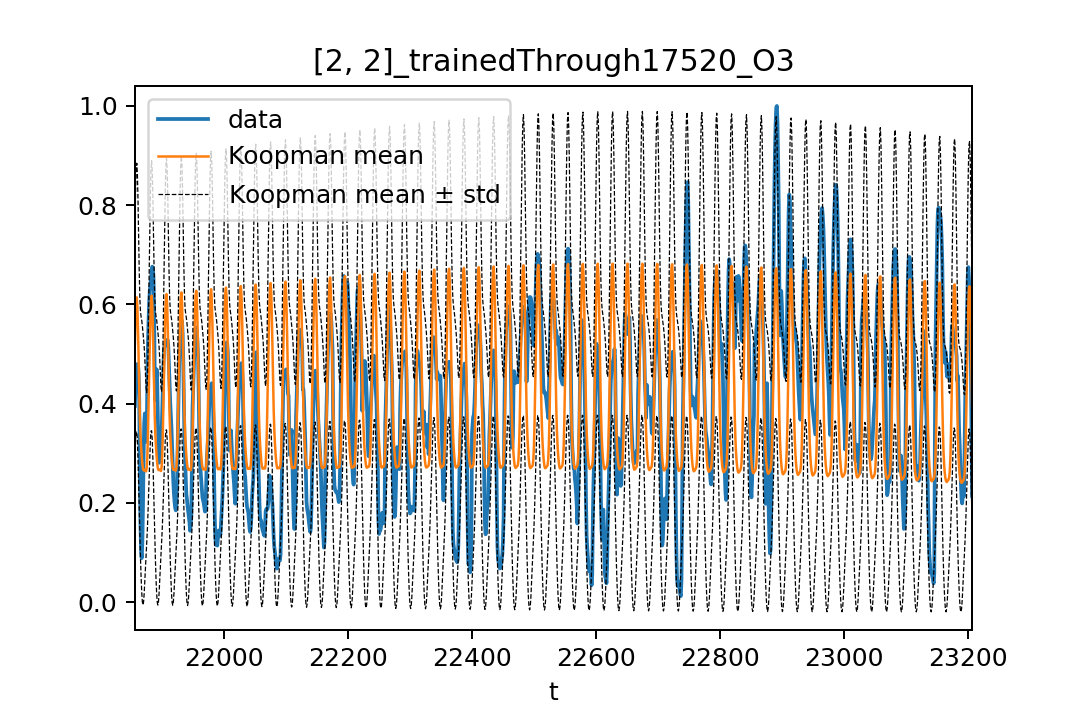

In [33]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    plt.plot(x[:predict_through, dim], label="data")
#     colors = [(i / len(quantiles), 0, 0) for i in range(len(quantiles))]
#     for j in range(0, len(quantiles), 1):
#         plt.plot(quant_preds[:, j], color=colors[j], linewidth=0.05, label=quantiles[j])
        
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

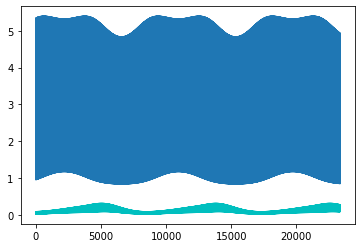

In [34]:
%matplotlib inline
plt.plot(a_hat)
plt.plot(1/rate_hat, color="c")

In [35]:
print("actual overall mean:", np.mean(xt), " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0.25223155380058526  predicted mean: 0.251418


In [38]:
a = 3
scale = 0.03
lins = np.linspace(1e-4, 1, 100)
gampdf = gamma.pdf(lins, a, scale=scale)

<IPython.core.display.Javascript object>


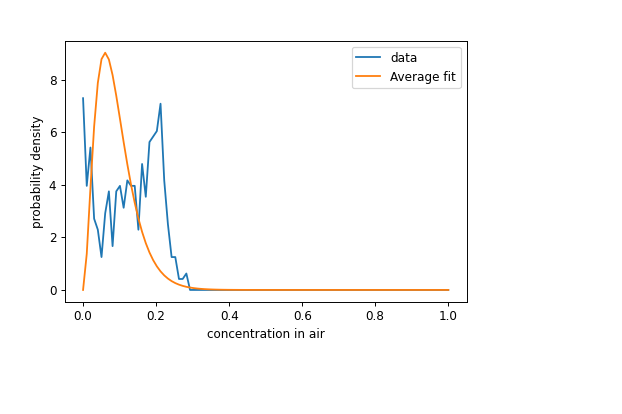

In [40]:
%matplotlib notebook
plt.figure()
hist, bin_edges = np.histogram(x[:24 * 20, 0], bins=100, range=(0, 1), density=True)
plt.plot(lins, hist, label="data")
plt.plot(lins, gampdf, label="Average fit")

plt.xlabel("concentration in air")
plt.ylabel("probability density")
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()

In [45]:
"mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

('mean of a_hat', 1.8193762, 'std of a_hat', 0.5413571)